# Dataset overview

Dataset information:
* **[count matrix](#Count-matrix-(X-and-layers))**:
    * `adata.X`: scaled count matrix, **2638 (cells) × 1838 (highly variable features)**
    * `adata.raw.X`: raw count matrix **2638 (cells) × 13714 (all used features) **
    * `adata.layers['logcounts']`: log-normalized count matrix, **2638 (cells) × 1838 (highly variable features)**
* **[obs](#obs---cells'-meta-information)**: cells' meta-information (e.g., number of features detected, leiden cluster) 
* **[var](#var---annotation-of-features)**: annotation of features (e.g., number of cells expressed, dispersions) 
* **[uns](#uns---unstructured-annotation)**: unstructured annotation (e.g., parameters for command, pca variance) 
* **[obsm](#obsm---dimensional-reduction-results)**: dimensional reduction results (e.g., pca, umap) 
* **[varm](#varm---feature-loadings)**: feature loadings
* **[layers](#Count-matrix-(X-and-layers))**: additional count matrix (e.g., logcounts) 
* **[obsp](#obsp---relationship-of-cells,-graphs)**: relationship of cells, graphs (distances, connectivities)

**Source**: modified from [Scanpy tutorials](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html)

# Generate dataset

In [1]:
import os
import scanpy as sc
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
display(HTML("<style>.container { width:83%; align: left; }</style>"))
display(HTML("<style>#toc-wrapper{ position: relative; width: 20%; top: 130px; left: 0px; }</style>"))
# change directory
os.chdir('/Users/soyabean/Desktop/tmp/scdown/benchmark')

/Applications/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.4 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


In [4]:
results_file = "write/pbmc3k.h5ad"

In [5]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique() 

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [8]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [10]:
# save raw counts in adata.raw
adata.raw = adata

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pp.log1p(adata)

In [13]:
# add log-normalization counts
adata.layers["logcounts"] = adata.X
adata.layers["logcounts"].toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.3781319, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
adata = adata[:, adata.var.highly_variable]

In [16]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [17]:
sc.tl.pca(adata, svd_solver="arpack")
adata.write(results_file)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [19]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


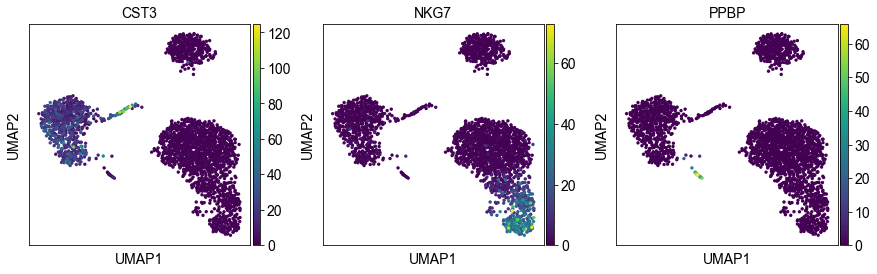

In [20]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

In [21]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [22]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


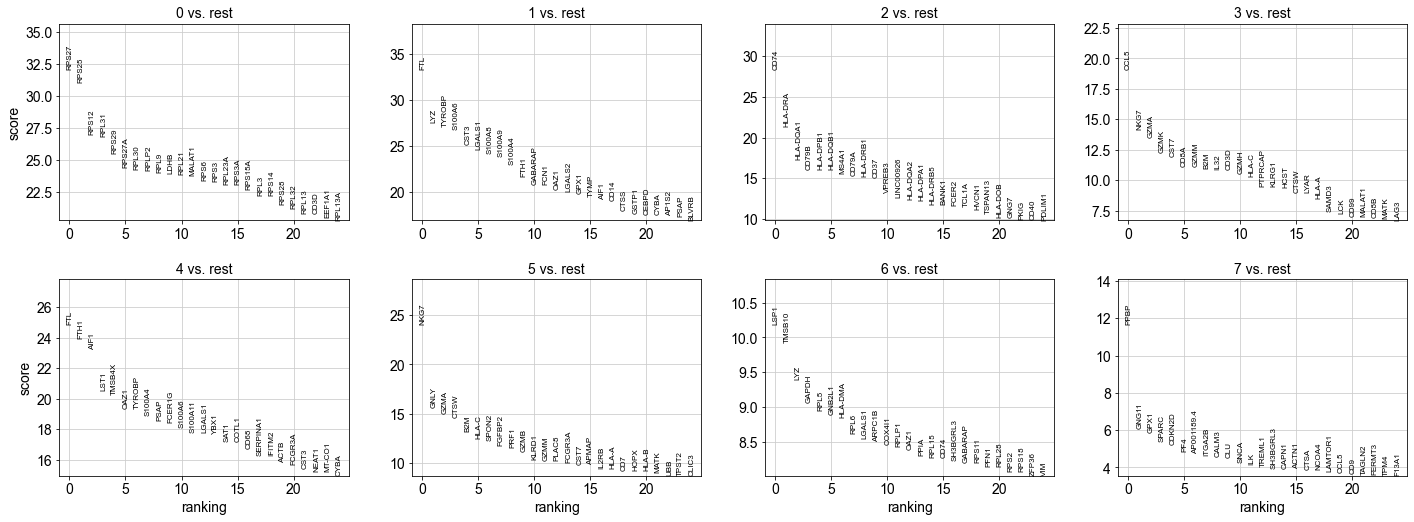

In [23]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


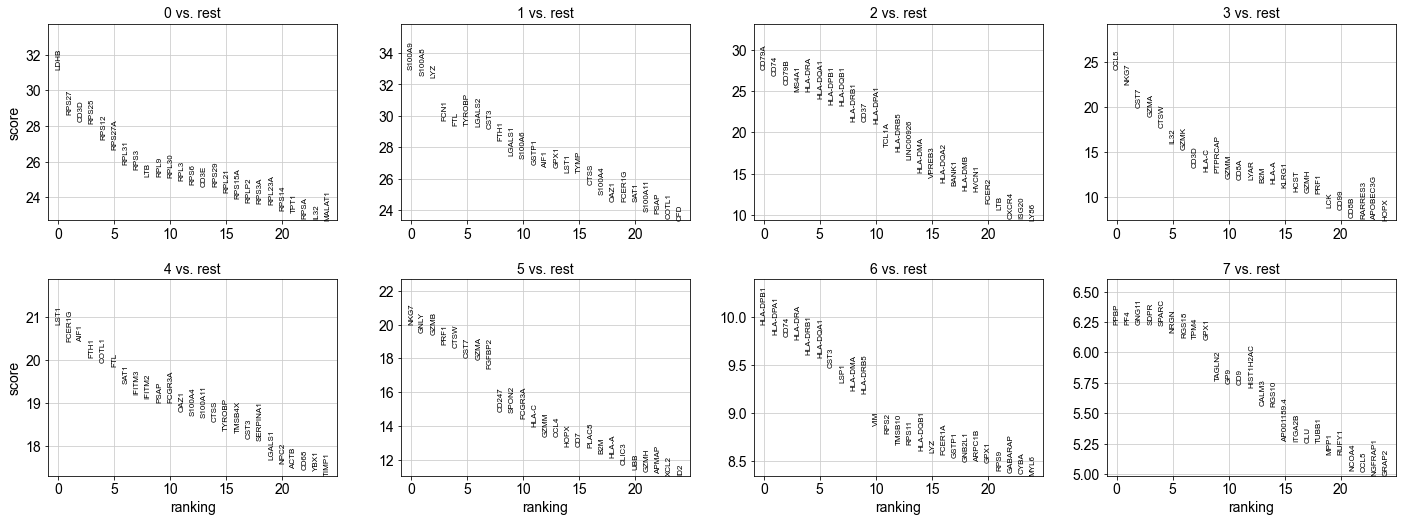

In [24]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [78]:
# add raw counts
adata.layers["rawcounts"] = adata.raw[:,adata.var.index.tolist()].X

In [79]:
adata.write(results_file)

# Detailed dataset information

In [26]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

## Count matrix (`X` and `layers`)

In [27]:
# raw count matrix
adata.raw.X.toarray()
# shape
adata.raw.X.shape

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(2638, 13714)

In [80]:
# raw count matrix in layers
adata.layers['rawcounts'].toarray()
# shape
adata.layers['rawcounts'].shape

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(2638, 1838)

In [28]:
# log-normalized count matrix
adata.layers['logcounts'].toarray()
# shape
adata.layers['logcounts'].shape

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.429744 ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.9370484],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

(2638, 1838)

In [29]:
# scaled count matrix
adata.X
# shape
adata.X.shape

array([[-0.17146961, -0.2808123 , -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865591,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106427,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378935, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

(2638, 1838)

## `obs` - cells' meta-information

In [30]:
adata.obs.head()
# shape
adata.var.shape

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,0
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,2
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,0
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,4
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,5


(1838, 13)

## `var` - annotation of features

In [31]:
adata.var.head()
# shape
adata.var.shape

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
TNFRSF4,ENSG00000186827,155,False,155,0.077407,94.259259,209.0,True,0.277410,2.086050,0.665406,-3.672069e-10,0.424481
CPSF3L,ENSG00000127054,202,False,202,0.094815,92.518519,256.0,True,0.385194,4.506987,2.955005,-2.372437e-10,0.460416
ATAD3C,ENSG00000215915,9,False,9,0.009259,99.666667,25.0,True,0.038252,3.953486,4.352607,8.472988e-12,0.119465
C1orf86,ENSG00000162585,501,False,501,0.227778,81.444444,615.0,True,0.678283,2.713522,0.543183,3.389195e-10,0.685145
RER1,ENSG00000157916,608,False,608,0.298148,77.481481,805.0,True,0.814813,3.447533,1.582528,7.696297e-11,0.736050


(1838, 13)

## `uns` - unstructured annotation

In [32]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([32.110455 , 18.718655 , 15.607329 , 13.235289 ,  4.802269 ,
        3.9859324,  3.5262327,  3.2334454,  3.1212087,  3.075261 ,
        2.9980748,  2.959521 ,  2.9517848,  2.9442477,  2.913872 ,
        2.8990302,  2.880682 ,  2.864685 ,  2.8430636,  2.8357508,
        2.8314214,  2.8182364,  2.8035524,  2.7999873,  2.788954 ,
        2.778101 ,  2.7705767,  2.7602205,  2.7538602,  2.7459552,
        2.7371864,  2.7341268,  2.722202 ,  2.7123108,  2.7024777,
        2.7000473,  2.6838503,  2.6790507,  2.6769078,  2.6739945,
        2.6648538,  2.6573114,  2.6511767,  2.6417756,  2.6329703,
        2.6295197,  2.6245294,  2.618376 ,  2.6180034,  2.6018658],
      dtype=float32), 'variance_ratio': array([0.02012819, 0.01173364, 0.00978333, 0.00829644, 0.00301027,
       0.00249855, 0.00221039, 0.00202686

In [33]:
# pca variance
adata.uns['pca']['variance']

array([32.110455 , 18.718655 , 15.607329 , 13.235289 ,  4.802269 ,
        3.9859324,  3.5262327,  3.2334454,  3.1212087,  3.075261 ,
        2.9980748,  2.959521 ,  2.9517848,  2.9442477,  2.913872 ,
        2.8990302,  2.880682 ,  2.864685 ,  2.8430636,  2.8357508,
        2.8314214,  2.8182364,  2.8035524,  2.7999873,  2.788954 ,
        2.778101 ,  2.7705767,  2.7602205,  2.7538602,  2.7459552,
        2.7371864,  2.7341268,  2.722202 ,  2.7123108,  2.7024777,
        2.7000473,  2.6838503,  2.6790507,  2.6769078,  2.6739945,
        2.6648538,  2.6573114,  2.6511767,  2.6417756,  2.6329703,
        2.6295197,  2.6245294,  2.618376 ,  2.6180034,  2.6018658],
      dtype=float32)

In [34]:
# pca parameters
adata.uns['pca']['params']

{'zero_center': True, 'use_highly_variable': True}

## `obsm` - dimensional reduction results

In [35]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [36]:
# dimensional reduction results of pca
adata.obsm['X_pca']

array([[-5.556221  , -0.25772715,  0.18679433, ..., -0.34272835,
         1.4820554 ,  1.8977244 ],
       [-7.209527  , -7.4820013 , -0.16271746, ..., -1.9744129 ,
        -1.5622702 , -1.49611   ],
       [-2.6944373 ,  1.5836617 ,  0.6631235 , ...,  0.544482  ,
        -0.5436244 , -4.3394427 ],
       ...,
       [-0.7853934 , -6.718591  , -1.5988475 , ..., -0.5608387 ,
        -0.10692333,  0.5838822 ],
       [ 0.28127232, -5.9218583 , -1.1628891 , ..., -1.3899633 ,
         3.5770402 ,  1.2988257 ],
       [-0.09076758, -0.6635025 , -0.13485482, ...,  0.37157103,
         0.75083363, -0.6659949 ]], dtype=float32)

In [37]:
# dimensional reduction results of umap
adata.obsm['X_umap']

array([[ 7.906657 ,  3.556091 ],
       [ 9.248348 , 12.544332 ],
       [ 7.629986 ,  3.8347855],
       ...,
       [ 7.2876377, 13.075106 ],
       [ 8.105372 , 14.307881 ],
       [ 8.511535 ,  3.3921196]], dtype=float32)

## `varm` - feature loadings

In [38]:
# feature loadings
adata.varm['PCs']

array([[-2.60148179e-02,  3.25416843e-03,  1.89788977e-03, ...,
        -5.18770702e-03,  1.44968908e-02, -6.67473301e-04],
       [-8.27822462e-03,  9.08316299e-03, -7.81411130e-04, ...,
         3.08727100e-02, -8.86981003e-03, -2.88053416e-03],
       [-3.31518659e-03,  3.20968428e-03,  2.79858650e-04, ...,
         1.01477914e-02, -5.30328136e-04,  1.50829612e-03],
       ...,
       [ 8.34176037e-03, -1.24651939e-03, -4.12195362e-03, ...,
        -1.01806019e-02,  9.22558550e-03,  2.79657058e-02],
       [-1.64065659e-02,  4.41013835e-02, -2.13347375e-05, ...,
         9.99553967e-03, -4.50964272e-03, -1.36533342e-02],
       [-1.51882619e-02,  4.00086790e-02,  5.41223399e-03, ...,
        -3.72782419e-03,  2.11074371e-02,  3.59644145e-02]])

##  `obsp` - relationship of cells, graphs

In [39]:
# relationship of cells, graphs
adata.obsp

PairwiseArrays with keys: distances, connectivities

In [40]:
adata.obsp['distances'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
adata.obsp['connectivities'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)